# Acoustic Experiments

## Imports

In [1]:
%pylab inline

import numpy as np
import scipy as sp
import scipy.constants as const

from scipy.io import wavfile
from sklearn import preprocessing
from scipy import signal

from scipy.signal import butter, firwin, lfilter
from scipy.signal import freqz
from scipy.signal import argrelextrema
from scipy.signal import argrelmax

Populating the interactive namespace from numpy and matplotlib


## Constants & Global Variables

In [2]:
input_data_directory = "data"
output_data_directory = "out"

sample_rate = 44100
tone_duration = 0.05
tone_frequency0 = 2000
tone_frequency1 = 6000

def normalize_audio(data):
    return data/0x7FFF

## Tone Generation

In [3]:
def generate_tone(frequency, duration, sample_rate):
    tone_data = np.sin(2 * math.pi * np.arange(math.ceil(sample_rate * duration)) * frequency / sample_rate) * 0x7FFF
    return tone_data

def get_tone_period(data, frequency):
    return tone_data[0:math.ceil(1/frequency*sample_rate)+1].squeeze()

def generate_chirp(frequency0, frequency1, duration, phase0=0, sample_rate=44100):
    num_samples = math.ceil(sample_rate * duration)
    samples = np.empty(num_samples)
    k = (frequency1 - frequency0)/num_samples
    for i in range(num_samples):
        samples[i] = math.sin(phase0+2*math.pi*(i*frequency0/sample_rate+k/2*i**2/sample_rate)) * 0x7FFF
    return samples

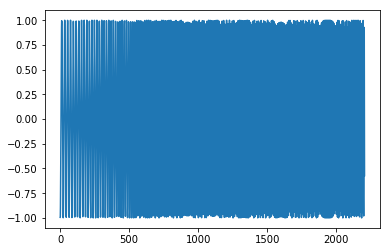

In [4]:
tone_data = generate_chirp(tone_frequency0, tone_frequency1, tone_duration, sample_rate)
# tone_data = scaler.fit_transform(np.reshape(tone_data,(tone_data.size,1)))
wavfile.write(input_data_directory+"/audio/chirp.wav", sample_rate, tone_data.astype(np.int16))
tone_data = normalize_audio(tone_data)

plt.figure()
plt.plot(tone_data)

## Load Sample Audio

### Filter Helper Function

In [5]:
# Source: http://stackoverflow.com/questions/12093594/how-to-implement-band-pass-butterworth-filter-with-scipy-signal-butter
def butter_bandpass(low_cut_frequency, high_cut_frequency, sample_rate, order=5):
    nyq = 0.5 * sample_rate
    low = low_cut_frequency / nyq
    high = high_cut_frequency / nyq
    b, a = butter(order, [low, high], btype='bandpass')
    return b, a

def butter_bandpass_filter(data, low_cut_frequency, high_cut_frequency, sample_rate, order=5):
    b, a = butter_bandpass(low_cut_frequency, high_cut_frequency, sample_rate, order=order)
    return lfilter(b, a, data)

def fir_bandpass(low_cut_frequency, high_cut_frequency, fs, order=5):
    nyq = 0.5 * fs
    b = firwin(order+1, [low_cut_frequency, high_cut_frequency], pass_zero=False, nyq=nyq)
    return b, [1.0]

def fir_bandpass_filter(data, low_cut_frequency, high_cut_frequency, fs, order=5):
    b, a = fir_bandpass(low_cut_frequency, high_cut_frequency, fs, order=order)
    return lfilter(b, a, data)    

### Visualize possible filters

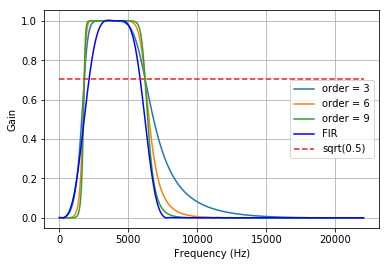

In [6]:
# Plot the frequency response for a few different filters and parameters.
plt.figure()
plt.clf()

low_cut_frequency = tone_frequency0 - 200
high_cut_frequency = tone_frequency1 + 200

for order in [3, 6, 9]:
    b, a = butter_bandpass(low_cut_frequency, high_cut_frequency, sample_rate, order=order)
    w, h = freqz(b, a, worN=2000)
    plt.plot((sample_rate * 0.5 / np.pi) * w, abs(h), label="order = %d" % order)

fir_order = 50
b, a = fir_bandpass(low_cut_frequency, high_cut_frequency, sample_rate, order=fir_order)
w, h = freqz(b)
plt.plot((sample_rate * 0.5 / np.pi) * w , abs(h), 'b', label="FIR")

plt.plot([0, 0.5 * sample_rate], [np.sqrt(0.5), np.sqrt(0.5)], '--', label='sqrt(0.5)')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Gain')
plt.grid(True)
plt.legend(loc='best')

In [7]:
def load_sample(path):
    sample_rate, sample_data = wavfile.read(path)
    return sample_rate, normalize_audio(sample_data)
       
def tone_filter(sample_data, tone_frequency0, tone_frequency1, tone_data, butler_order=3):
    filtered_sample_data = butter_bandpass_filter(sample_data,
                                                  tone_frequency0-200,
                                                  tone_frequency1+200,
                                                  sample_rate,
                                                  order=butler_order)
    correlation = sp.correlate(filtered_sample_data, tone_data, 'valid')
    absolute_correlation = np.absolute(correlation)
    return absolute_correlation

def tone_recognition(sample_data, sample_rate, duration):
    last_index = 0
    tones = []
    tone_candidates = argrelmax(sample_data, order=math.ceil(duration*sample_rate*2))[0]
    for candidate in tone_candidates:
        tones.append((candidate, sample_data[candidate]))
    tones.sort(key=lambda tup: tup[1])
    tones.reverse()
    
    return tones

def compute_etoa(tones, sample_rate):
    if len(tones) < 2:
        raise NameError("Insufficient Tones Detected")
    else:
        return abs(tones[0][0]-tones[1][0])/sample_rate
    
def compute_distance(etoa_a, etoa_b, d_aa, d_bb, c=340.29):
    return (c/2) * (etoa_a - etoa_b) + (d_aa + d_bb)

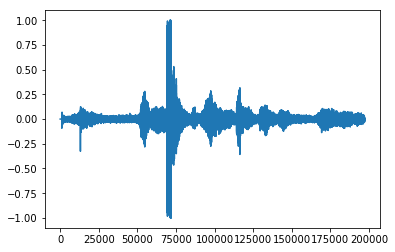

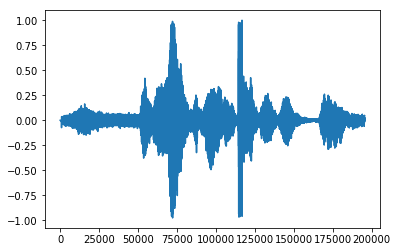

In [49]:
device_a_sample_rate, device_a_sample_data = load_sample(input_data_directory+"/audio/trial-2-chirp-1m-da.wav")
plt.figure()
plt.plot(device_a_sample_data)

device_b_sample_rate, device_b_sample_data = load_sample(input_data_directory+"/audio/trial-2-chirp-1m-db.wav")
plt.figure()
plt.plot(device_b_sample_data)

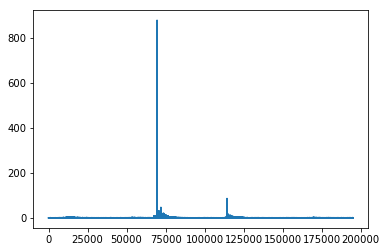

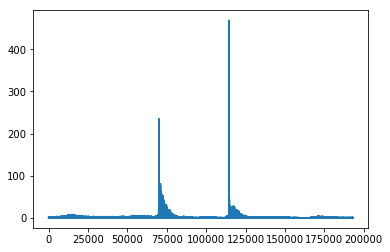

In [50]:
device_a_correlation = tone_filter(device_a_sample_data,
                                   tone_frequency0,
                                   tone_frequency1,
                                   tone_data)
plt.figure()
plt.plot(device_a_correlation)

device_b_correlation = tone_filter(device_b_sample_data,
                                   tone_frequency0,
                                   tone_frequency1,
                                   tone_data)
plt.figure()
plt.plot(device_b_correlation)

In [51]:
device_a_tones = tone_recognition(device_a_correlation, sample_rate, tone_duration)
print("Device A")
for tone in device_a_tones:
    print("Sample:",tone[0],"Value:",tone[1])        
print("A total of",len(device_a_tones),"tones were detected.")

print("Device B")
device_b_tones = tone_recognition(device_b_correlation, sample_rate, tone_duration)
for tone in device_b_tones:
    print("Sample:",tone[0],"Value:",tone[1])
print("A total of",len(device_b_tones),"tones were detected.")

Device A
Sample: 69498 Value: 878.699920235
Sample: 114290 Value: 86.466008704
Sample: 12664 Value: 3.10732052787
Sample: 169736 Value: 2.183874614
Sample: 59149 Value: 1.88072046877
Sample: 100111 Value: 1.70882616704
Sample: 39988 Value: 1.63726363311
Sample: 191709 Value: 1.61465809345
Sample: 179023 Value: 1.56066320918
Sample: 134190 Value: 1.48822239032
Sample: 156927 Value: 1.42368563632
Sample: 148427 Value: 1.38387657159
Sample: 1176 Value: 1.37707649892
A total of 13 tones were detected.
Device B
Sample: 114585 Value: 468.75670394
Sample: 70026 Value: 235.406256794
Sample: 15116 Value: 8.21383899075
Sample: 53674 Value: 6.10465514092
Sample: 61287 Value: 5.50457246415
Sample: 171008 Value: 4.71655616154
Sample: 46646 Value: 4.2316949761
Sample: 28606 Value: 4.19473455668
Sample: 37593 Value: 3.55314695986
Sample: 102362 Value: 2.63579254108
Sample: 146086 Value: 2.08569352105
Sample: 183432 Value: 1.5707615411
Sample: 192638 Value: 1.13288906166
A total of 13 tones were detec

In [52]:
device_a_etoa = compute_etoa(device_a_tones, sample_rate)
print("Device A ETOA:",device_a_etoa)

device_b_etoa = compute_etoa(device_b_tones, sample_rate)
print("Device B ETOA:",device_b_etoa)

Device A ETOA: 1.01569160998
Device B ETOA: 1.01040816327


In [53]:
distance = compute_distance(device_a_etoa, device_b_etoa, 0.04, 0.04)
distance

0.97895204081633524